In [1]:
RESUME_DIR = '/home/jianli/new'  #下载的简历存放地址

GREET_MSG="""你好，可以发一份简历过来吗 """ #打招呼用语
from bossbot import BossBot
import time,random


In [2]:
codes = {}  # 记录boss的job_id 和自己的job_id的映射

class Bot(BossBot):
    
    def check_info_and_first_greet(self,uid,greet_msg):
        '''
        获取达人信息 如果是没聊过就发消息
        '''
        info  = self.geek_info(uid)
        if info and not info['bothTalked'] and info['edu'] in('博士','硕士','本科') and info['note']!='已聊':
            # 第一次打招呼
            self.send_message(uid, greet_msg)
            self.exchange_request(uid)
            self.change_note(info, '已聊')
            return True,info
        return False,info
    

    def on_text_message(self, data, uid, msg):
        '''
        文本 消息回调函数。
        :param data: 收到的完整消息内容
        :param uid: 发送次消息的boss的id
        :param msg: 文本内容
        :return:
        '''
        is_greet,info = self.check_info_and_first_greet(uid,GREET_MSG)
        print('收到文字消息:' + msg)
    
    def on_connect(self, client, userdata, flags, rc):
        '''
        websocket连接成功回调函数。
        :param client: 
        :param userdata: 
        :param flags: 
        :param rc: 
        :return: 
        '''
        print("websocket 连接成功！")
    
    def download_resume(self,info):
        '''
        下载简历
        '''
        if 'toPositionId' not in info:
            print(info)
        if info['toPositionId'] not in codes:
            print('-------=-=-=-',info['toPositionId'],info['toPosition'])
            return 
        job_code=codes.get(info['toPositionId'])
        filename_jobcode = '【'+code+'】' if job_code  else ''
        print("简历下载开始 job_code:",filename_jobcode)
        
        PATH=RESUME_DIR+'/'
        if 'encryptUid' not in info:
            return 
        url='https://docdownload.zhipin.com/wflow/zpgeek/download/download4boss/'+info['encryptUid']
        r=self.session.get(url)
        print(r.headers)
        
        import urllib
        
        if not r.headers.get('Content-Disposition'):
            return
        filename_info = [i.strip().split('=',1) for i in  urllib.parse.unquote(r.headers['Content-Disposition'].encode('ISO-8859-1').decode('utf8')).split(';')]
        filename_org = [i[1] for i in filename_info if i[0]=='filename'][0].replace('"','').replace('/','')
        filename_f = filename.split('.',1)
        filename = filename_f[0]+filename_jobcode+'.'+filename_f[1]
        fo = open(PATH+filename,'wb')
        fo.write(r.content)
        fo.close()
        print("简历下载完成 ",r.headers['Content-Disposition'],filename)
        self.change_note(info, '简历已下载')
    
    
    def deal_history_chat_and_donwload(self):
        import time 
        friends=list(self.friends.keys())
        for uid in friends:
            time.sleep(0.4)
            is_greet,info = self.check_info_and_first_greet(uid,GREET_MSG)
            
            if info and info['bothTalked'] and info['edu'] in('博士','硕士','本科') and info['note']!='简历已下载':
                r=self.get_his_msg(uid)
                for msg in r.json()['zpData']['messages'][-3:]:
                    if msg['body']['type']==7:
                        self.exchange_accept(msg['mid'],msg['from']['uid'])
                        print('0------',info.get('resumeVisible','-=-='))

            if info and info['edu'] in('博士','硕士','本科') and info['resumeVisible']==1 and info['note']!='简历已下载' : 
                self.download_resume(info)
                    
    def download_all_reusme(self):
        friends=list(self.friends.keys())
        for uid in friends:
            info = self.geek_info(uid)
            if info['resumeVisible']==1 and info['note']!='简历已下载' :
                self.download_resume(info)


    def _sayhello(self,info):
        time.sleep(0.5+(random.randint(3,9)/10))
        start_chat_param={
        'gid': info['encryptGeekId'] , 
        # 'suid':'',
        'jid':  info['geekCard']['encryptJobId'] ,
        'expectId': info['geekCard']['expectId'],  
        'lid':  info['geekCard']['lid'] , 
        # 'from': '',
        'securityId':info['geekCard']['securityId'] 
            }

        rrr = bot.session.post('https://www.zhipin.com/wapi/zpjob/chat/start?_=%d'%int(time.time() * 1000)
                         ,data=start_chat_param
                        )
        print(rrr.text)
    
    
    def sayhello_newgeek(self,n):
        '''
        打招呼 - 新人
        '''
        get_geek_params ={
            "age": "16,-1",
            "gender": 0,
            "exchangeResumeWithColleague": 0,
            "switchJobFrequency": 0,
            "activation": 0,
            "recentNotView": 0,
            "school": "1104,1103,1102,1105,1106",
            "experience": 0,
            "degree": "203,204,205",
            "salary": 0,
            "intention": 0,
            "jobid": -1,
            "page": 1,
            "tag": 1,
            "status": 1,
            "coverScreenMemory": 1,
               '_': int(time.time() * 1000)
        }
        rr=self.session.get('https://www.zhipin.com/wapi/zprelation/interaction/bossGetGeek',params=get_geek_params)
        infos = rr.json()['zpData']['geekList']
        for i in range(n):
            info=infos[i]
            self._sayhello(info)
    
    def sayhello_randjob(self,n):
        '''
        打招呼 - 按不同职位
        '''
        jobs=self.get_jobs()
        import random 
        list_params={
            'age': '16,-1',
            'gender': 0,
            'exchangeResumeWithColleague': 0,
            'switchJobFrequency': 0,
            'activation': 0,
            'recentNotView': 0,
            "school": "1104,1103,1102,1105,1106",
            'major': 0,
            'experience': 0,
            "degree": "203,204,205",
            'salary': 0,
            'intention': 0,
            'jobId': jobs[random.randint(0,len(jobs)-1)][0],
            'page': 1,
            'coverScreenMemory': 0,
            '_': int(time.time() * 1000)
        }
        rr=self.session.get("https://www.zhipin.com/wapi/zpjob/rec/geek/list",params=list_params)
        infos = rr.json()['zpData']['geekList']
        for i in range(n):
            info=infos[i]
            self._sayhello(info)
            
    def post_job(self,job_name,desc,city):
        '''
        发职位

        :param job_name: 职位名称
        :param desc: 职位描述 
        :param city: 城市
        :return:
        '''
        city_map={ # 记录城市和 boss上的地址代码的关系
            '北京':'[{"addressText":"","encRelationId":""}]',
        }
        import time 
        eidt_url='https://www.zhipin.com/wapi/zpjob/job/edit?hasProxy=1&_=%d'%int(time.time() * 1000)
        edit_flag = self.session.get(eidt_url).json()['zpData']['editFlag']
        predict_url='https://www.zhipin.com/wapi/zpjob/job/position/predict?_=%d'%int(time.time() * 1000)
        para={
            'jobName':job_name,
            'jobDesc':desc,
            'jobType':0,
            'editFlag':edit_flag,
        }
        r = self.session.post(predict_url, data=para)
        code = r.json().get('zpData',{}).get('recommendPosition',{}).get('config',{}).get('code')
        if not code:
            print('没有code')
            return
        name = r.json()['zpData']['recommendPosition']['config']['name']
        print('name code ',name,code)
        save_url='https://www.zhipin.com/wapi/zpjob/job/save?_=%d'%int(time.time() * 1000)
        para={
        'comId': '',
        'brandId': '',
        'positionName': job_name,
        'positionCategory': name,
        'position': code,
        'degree': 203,
        'skill[]': name,
        'skill[]': 'Python',

        'jobType': 0,
        'experience': 101,
        'lowSalary': 25,
        'highSalary': 50,
        'salaryMonth': 15,
        'leastMonth': 3,
        'daysPerWeek': '',
        'performance': '',
        'description': desc,
        'department': '',
        'reportObject': '',
        'graduateYear': '',
        'recruitEndTime': '',
        'anonymous': 0,
        'requireIndustries': '',
        'requireIndustriesDesc': '',
        'trainingPlan': '',
        'workday': 0,
        'salaryType': 0,
        'acType': 2501,
        'periodType': 2,
        'period': '',
        'deadline': '',
        'basicSalary': 0,
        'highBasicSalary': 0,
        'salaryDay': 0,
        'socialInsuranceType': 0,
        'other': '',
        'createType': 0,
        'probation': '',
        'socialInsuranceTypeName': '',
        'preferenceJsonStr': '',
        'knowBlueIntermediaryTip': 0,
        'proxyType': 0,
        'performanceExplain': '',
        'relationIdJson': city_map[city],
        'phoneAssistantStatus': 0,
        'proxySelfFlag': True,
        'mustAnonymous': False,
        'workType': 0,
        'workArea': '',
        'needProxyCom': False,
        'spreadCity': '',
        'editFlag': edit_flag
        }
        r = self.session.post(save_url, data=para)
        job_id = r.json().get('zpData',{}).get('jobId')
        print('name code ',job_name,r.json())

               

# 如何获取这三个参数 uid \ token \ wt2

## 网页打开boss直聘登录，F12调出控制台，搜索‘batchRunV3’这个请求，看它的respons 得到userId和token，这两个参数相对固定获取一次就不用更新了



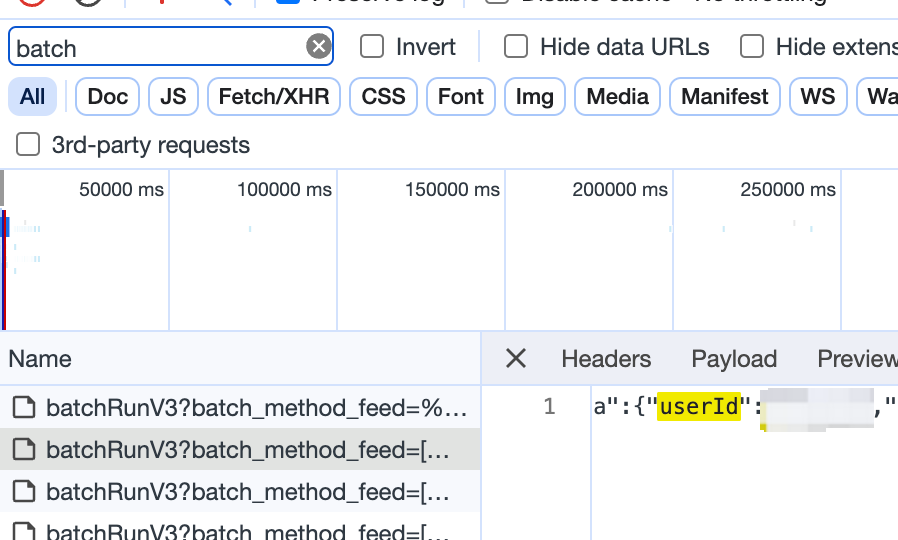



## 进入application tab cookie  这里获取wt2    这个参数每次重新登陆的话就不一样了 
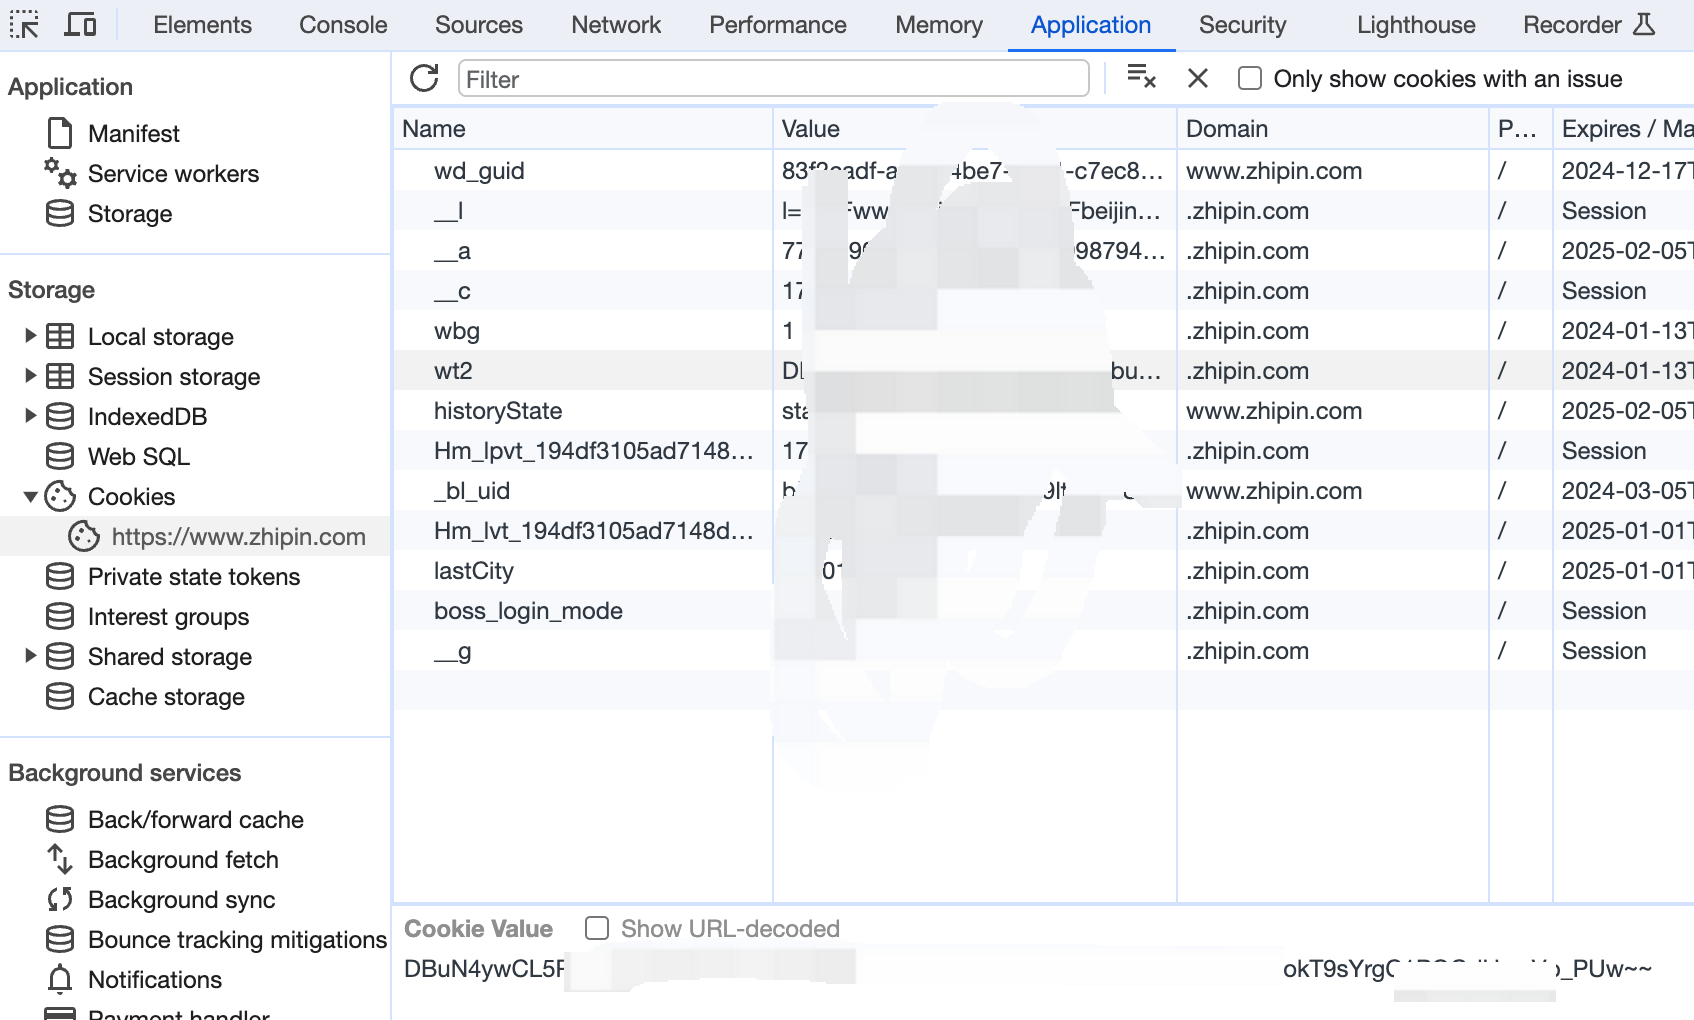

In [3]:
uid= '312342345291'
token='8hUdfffwc645GH'
wt2='DLEK99k_p234pvk4k9AFTskwiKuNksodkjKjdsfwoNP6PSqk5ChKVfxwZCtZqzyTFXu8EEoq3kCghl7rvdZg~~'

bot = Bot()
bot.login(uid= uid,user_id=wt2,token=token)
bot.start()

In [ ]:
bot.get_chats()  ##获取最近对话
bot.deal_history_chat_and_donwload() ##下载处理历史对话

In [ ]:
bot.sayhello_randjob(5)
bot.sayhello_randjob(5)
bot.sayhello_randjob(5)


In [ ]:
bot.sayhello_newgeek(15)

_on_message None <paho.mqtt.client.MQTTMessage object at 0x10842a570>
receive:  {"type": 4, "iqResponse": {"qid": 0, "query": "/message/suggest", "results": [{"key": "friend_source", "value": "0"}, {"key": "suggestions", "value": "[]"}, {"key": "friendId", "value": "102488365"}, {"key": "msg_id", "value": "486301624553"}, {"key": "business_scene_type", "value": "1"}]}}
_on_message None <paho.mqtt.client.MQTTMessage object at 0x10842a570>
receive:  {"type": 6, "messageRead": [{"userId": 102488365, "messageId": 486153834154, "readTime": 1694757492}], "domain": 1}
_on_message None <paho.mqtt.client.MQTTMessage object at 0x10842a570>
receive:  {"type": 6, "messageRead": [{"userId": 102488365, "messageId": 486301625492, "readTime": 1694757492}], "domain": 1}
_on_message None <paho.mqtt.client.MQTTMessage object at 0x10842a570>
receive:  {"type": 1, "messages": [{"from": {"uid": 31964291, "name": "曾政", "avatar": "https://img.bosszhipin.com/boss/avatar/avatar_15.png", "company": "", "headImg"